Aplicar o CRISP-DM e montar um material de apresentação considerando até a etapa de avaliação do modelo.

Sobre o Conjunto de Dados
Marketing Bancário

Resumo:
Os dados estão relacionados com campanhas de marketing direto (ligações telefônicas) de uma instituição bancária portuguesa. O objetivo da classificação é prever se o cliente irá subscrever um depósito a prazo (variável y).

Informações do Conjunto de Dados:
Os dados estão relacionados com campanhas de marketing direto de uma instituição bancária portuguesa. As campanhas de marketing foram baseadas em ligações telefônicas. Muitas vezes, mais de um contato com o mesmo cliente foi necessário para avaliar se o produto (depósito a prazo bancário) seria ('sim') ou não ('não') subscrito.

Fonte:

	Conjunto de dados de: http://archive.ics.uci.edu/ml/datasets/Bank+Marketing#


# Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from scipy import stats

# Dados

In [4]:
# Abrir os dados disponíveis
df_bank_full = pd.read_csv(r'C:\Users\kawda\OneDrive\Desktop\Data_Science\Semana_7\Tarefa\Produto_Bancario\bank-additional-full.csv', sep=';')
df_bank_full.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


# Identificar e separar o target e fazer o test-split

In [5]:
# Verificar os dados e separar o target
X = df_bank_full.drop(columns='y')
y = df_bank_full['y']

# Split the data into train and test sets
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=88)

X_train.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
21740,31,technician,single,university.degree,no,no,yes,cellular,aug,tue,60,6,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1
1321,35,blue-collar,married,basic.9y,unknown,no,no,telephone,may,thu,170,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0
25125,31,blue-collar,married,basic.9y,no,yes,no,cellular,nov,tue,60,2,999,0,nonexistent,-0.1,93.200,-42.0,4.153,5195.8
3159,44,blue-collar,married,basic.4y,unknown,no,no,telephone,may,thu,139,2,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0
35424,41,admin.,single,high.school,no,no,no,cellular,may,mon,722,4,999,0,nonexistent,-1.8,92.893,-46.2,1.244,5099.1


## Lista de Variáveis e Suas Descrições

### Dados do Cliente Bancário
- **age**: Idade do cliente.  
- **job**: Tipo de trabalho do cliente.  
- **martial**: Estado civil do cliente.  
- **education**: Nível de escolaridade do cliente.  
- **default**: Indica se o cliente tem crédito em default.  
- **housing**: Indica se o cliente possui um empréstimo habitacional.  
- **loan**: Indica se o cliente possui um empréstimo pessoal.  

### Relacionado ao Último Contato da Campanha Atual
- **contact**: Tipo de comunicação utilizada no contato com o cliente.  
- **month**: Último mês em que o cliente foi contatado.  
- **day_of_week**: Último dia da semana em que o cliente foi contatado.  
- **duration**: Duração do último contato, em segundos.  

### Outros Atributos
- **campaign**: Número de contatos realizados durante a campanha atual para este cliente.  
- **pdays**: Número de dias desde o último contato do cliente em uma campanha anterior.  
- **previous**: Número de contatos realizados antes desta campanha para este cliente.  
- **poutcome**: Resultado da campanha de marketing anterior.  

### Atributos de Contexto Social e Econômico
- **emp.var.rate**: Taxa de variação do emprego (indicador trimestral).  
- **cons.price.idx**: Índice de preços ao consumidor (indicador mensal).  
- **cons.conf.idx**: Índice de confiança do consumidor (indicador mensal).  
- **euribor3m**: Taxa Euribor de 3 meses (indicador diário).  
- **nr.employed**: Número de empregados (indicador trimestral).  

### Variável de Saída (Alvo)
- **y**: Indica se o cliente subscreveu um depósito a prazo.  


# Data Preparation

## Tratamento inicial padrão (Alta porcentagem de nulos, Variáveis constantes, Missings)

In [6]:
def get_metadata(dataframe):
	# Coleta de metadados básicos
	metadata = pd.DataFrame({
		'nome_variavel': dataframe.columns,
		'tipo': dataframe.dtypes,
		'qt_nulos': dataframe.isnull().sum(),
		'percent_nulos': round((dataframe.isnull().sum() / len(dataframe)) * 100, 2),
		'cardinalidade': dataframe.nunique(),
	})

	# Função para testar normalidade usando o teste de D'Agostino e Pearson
	def test_normality(series, alpha=0.05):
		if series.dtype in ["float64", "int64", "int32"]:
			statistic, p_value = stats.normaltest(series.dropna())  # dropping NA values for the test
			return p_value > alpha
		else:
			return None  # Return None for non-numeric data types

	# Aplicando teste de normalidade
	metadata["fl_normal"] = dataframe.apply(test_normality)

	metadata = metadata.sort_values(by='percent_nulos', ascending=False)
	metadata = metadata.reset_index(drop=True)

	return metadata

# Apply the function to the dataframe
metadados = get_metadata(X_train)
metadados

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade,fl_normal
0,age,int64,0,0.0,76,False
1,job,object,0,0.0,12,None
2,euribor3m,float64,0,0.0,305,False
3,cons.conf.idx,float64,0,0.0,26,False
4,cons.price.idx,float64,0,0.0,26,False
5,emp.var.rate,float64,0,0.0,10,False
6,poutcome,object,0,0.0,3,None
7,previous,int64,0,0.0,8,False
8,pdays,int64,0,0.0,26,False
9,campaign,int64,0,0.0,39,False


In [7]:
def preprocess_dataframe(df):
	# Drop columns with >80% missing values
	total_count = len(df)
	columns_to_drop = [col for col in df.columns if df[col].isnull().sum() / total_count > 0.8]
	df = df.drop(columns=columns_to_drop)
	
	# Replace missing values
	for col_name in df.columns:
		data_type = df[col_name].dtype
		
		if np.issubdtype(data_type, np.number):
			mean_value = df[col_name].mean()
			df[col_name] = df[col_name].fillna(mean_value)
		elif data_type == object:
			df[col_name] = df[col_name].fillna("Desconhecido")
	
	# Drop columns with variance equals to 0
	numeric_columns = df.select_dtypes(include=[np.number]).columns
	variances = df[numeric_columns].var()
	columns_to_drop = variances[variances == 0].index.tolist()
	df = df.drop(columns=columns_to_drop)
	
	return df

# Apply the function to the dataframe
abt_02 = preprocess_dataframe(X_train)
abt_02.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
21740,31,technician,single,university.degree,no,no,yes,cellular,aug,tue,60,6,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1
1321,35,blue-collar,married,basic.9y,unknown,no,no,telephone,may,thu,170,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0
25125,31,blue-collar,married,basic.9y,no,yes,no,cellular,nov,tue,60,2,999,0,nonexistent,-0.1,93.200,-42.0,4.153,5195.8
3159,44,blue-collar,married,basic.4y,unknown,no,no,telephone,may,thu,139,2,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0
35424,41,admin.,single,high.school,no,no,no,cellular,may,mon,722,4,999,0,nonexistent,-1.8,92.893,-46.2,1.244,5099.1


# Processamentos das variáveis

## Tratamento de variáveis numéricas (Padronização)

In [8]:
def normalize_dataframe(df):
	# Instanciando o scaler
	scaler = StandardScaler()

	# Selecionando colunas numéricas
	numeric_cols = df.select_dtypes(include=['float64', 'int64', 'int32']).columns

	# Aplicando a normalização
	df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

	return df

# Apply the function to the dataframe
abt_03 = normalize_dataframe(abt_02)

# Show the result
abt_03.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
21740,-0.866347,technician,single,university.degree,no,no,yes,cellular,aug,tue,-0.762692,1.265698,0.195464,-0.347517,nonexistent,0.835936,-0.233955,0.950295,0.770424,0.842930
1321,-0.483082,blue-collar,married,basic.9y,unknown,no,no,telephone,may,thu,-0.340152,-0.571768,0.195464,-0.347517,nonexistent,0.644680,0.719336,0.885340,0.708122,0.329971
25125,-0.866347,blue-collar,married,basic.9y,no,yes,no,cellular,nov,tue,-0.762692,-0.204275,0.195464,-0.347517,nonexistent,-0.120341,-0.656869,-0.327147,0.303159,0.396338
3159,0.379263,blue-collar,married,basic.4y,unknown,no,no,telephone,may,thu,-0.459232,-0.204275,0.195464,-0.347517,nonexistent,0.644680,0.719336,0.885340,0.711006,0.329971
35424,0.091815,admin.,single,high.school,no,no,no,cellular,may,mon,1.780227,0.530712,0.195464,-0.347517,nonexistent,-1.204122,-1.188979,-1.236513,-1.374957,-0.940675


## Tratamento de variáveis categóricas

### Baixa Cardinalidade (Dummy)

In [9]:
def apply_onehot_encoding(df, metadata, card_cutoff=5):
	# Filtrar variáveis categóricas de baixa cardinalidade
	df_categ_onehot = metadata[(metadata['cardinalidade'] <= card_cutoff) & (metadata['tipo'] == 'object')]
	lista_onehot = list(df_categ_onehot.nome_variavel.values)
	print('Lista de vars para OneHot Encoding: ', lista_onehot)

	# Instanciar o encoder
	encoder = OneHotEncoder(drop='first', sparse_output=False)

	# Aplicar o one-hot encoding
	encoded_data = encoder.fit_transform(df[lista_onehot])

	# Criar um DataFrame com as colunas codificadas, mantendo o índice original
	encoded_cols = encoder.get_feature_names_out(lista_onehot)
	encoded_df = pd.DataFrame(encoded_data, columns=encoded_cols, index=df.index)

	# Concatenar o DataFrame codificado com o DataFrame original
	df = pd.concat([df.drop(lista_onehot, axis=1), encoded_df], axis=1)

	return df

# Apply the function to the dataframe
abt_04 = apply_onehot_encoding(abt_03, metadados)
abt_04.head()

Lista de vars para OneHot Encoding:  ['poutcome', 'day_of_week', 'contact', 'loan', 'housing', 'default', 'marital']


,age,job,education,month,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,...,contact_telephone,loan_unknown,loan_yes,housing_unknown,housing_yes,default_unknown,default_yes,marital_married,marital_single,marital_unknown
21740,-0.866347,technician,university.degree,aug,-0.762692,1.265698,0.195464,-0.347517,0.835936,-0.233955,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1321,-0.483082,blue-collar,basic.9y,may,-0.340152,-0.571768,0.195464,-0.347517,0.644680,0.719336,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
25125,-0.866347,blue-collar,basic.9y,nov,-0.762692,-0.204275,0.195464,-0.347517,-0.120341,-0.656869,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3159,0.379263,blue-collar,basic.4y,may,-0.459232,-0.204275,0.195464,-0.347517,0.644680,0.719336,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
35424,0.091815,admin.,high.school,may,1.780227,0.530712,0.195464,-0.347517,-1.204122,-1.188979,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Alta Cardinalidade (Label Encoding)

In [10]:
def apply_label_encoding(df, metadata, card_cutoff=5):
	# Filtrar variáveis categóricas de alta cardinalidade
	df_categ_labelenc = metadata[(metadata['cardinalidade'] > card_cutoff) & (metadata['tipo'] == 'object')]
	lista_lenc = list(df_categ_labelenc.nome_variavel.values)
	print('Lista de vars para Label Encoding: ', lista_lenc)

	# Aplicando LabelEncoder nas colunas desejadas
	for col in lista_lenc:
		encoder = LabelEncoder()
		df[col] = encoder.fit_transform(df[col])

	return df

# Apply the function to the dataframe
abt_05 = apply_label_encoding(abt_04, metadados)
abt_05.head()

Lista de vars para Label Encoding:  ['job', 'month', 'education']


,age,job,education,month,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,...,contact_telephone,loan_unknown,loan_yes,housing_unknown,housing_yes,default_unknown,default_yes,marital_married,marital_single,marital_unknown
21740,-0.866347,9,6,1,-0.762692,1.265698,0.195464,-0.347517,0.835936,-0.233955,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1321,-0.483082,1,2,6,-0.340152,-0.571768,0.195464,-0.347517,0.644680,0.719336,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
25125,-0.866347,1,2,7,-0.762692,-0.204275,0.195464,-0.347517,-0.120341,-0.656869,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3159,0.379263,1,0,6,-0.459232,-0.204275,0.195464,-0.347517,0.644680,0.719336,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
35424,0.091815,0,3,6,1.780227,0.530712,0.195464,-0.347517,-1.204122,-1.188979,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Juntar os dados sensíveis

In [11]:
# Inner join usando o índice
abt_model = pd.merge(abt_05, y_train, left_index=True, right_index=True, how='inner')
abt_model['y'] = abt_model['y'].map({'yes': 1, 'no': 0})
abt_model.head()

,age,job,education,month,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,...,loan_unknown,loan_yes,housing_unknown,housing_yes,default_unknown,default_yes,marital_married,marital_single,marital_unknown,y
21740,-0.866347,9,6,1,-0.762692,1.265698,0.195464,-0.347517,0.835936,-0.233955,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1321,-0.483082,1,2,6,-0.340152,-0.571768,0.195464,-0.347517,0.644680,0.719336,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0
25125,-0.866347,1,2,7,-0.762692,-0.204275,0.195464,-0.347517,-0.120341,-0.656869,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
3159,0.379263,1,0,6,-0.459232,-0.204275,0.195464,-0.347517,0.644680,0.719336,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0
35424,0.091815,0,3,6,1.780227,0.530712,0.195464,-0.347517,-1.204122,-1.188979,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1


In [12]:
df_bank_full.iloc[[21740, 1321, 25125, 3159, 35424]]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
21740,31,technician,single,university.degree,no,no,yes,cellular,aug,tue,...,6,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,no
1321,35,blue-collar,married,basic.9y,unknown,no,no,telephone,may,thu,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
25125,31,blue-collar,married,basic.9y,no,yes,no,cellular,nov,tue,...,2,999,0,nonexistent,-0.1,93.200,-42.0,4.153,5195.8,no
3159,44,blue-collar,married,basic.4y,unknown,no,no,telephone,may,thu,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,no
35424,41,admin.,single,high.school,no,no,no,cellular,may,mon,...,4,999,0,nonexistent,-1.8,92.893,-46.2,1.244,5099.1,yes


### Feature Selection

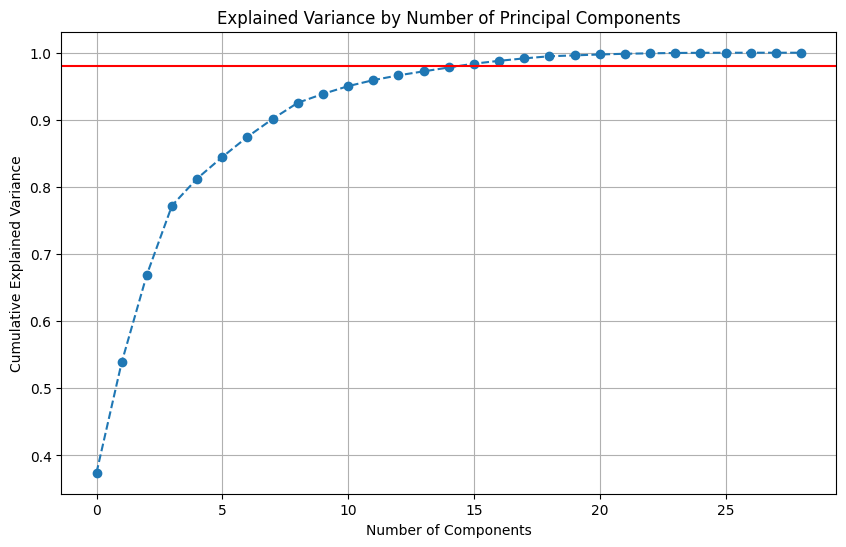

Number of components needed to explain at least 98.0% variance: 16


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,y
0,5.661101,-3.675818,0.747526,0.704452,0.104176,-0.471968,-1.043881,-0.354380,1.369019,-0.392098,0.063120,-0.580348,-0.552909,-0.112752,-0.504208,-0.629454,0
1,-2.995754,1.440737,-1.702533,1.343445,-0.370121,0.138259,0.249964,-0.996133,0.363471,0.317543,0.096066,0.575751,-0.386666,0.810860,0.456631,-0.034932,0
2,-3.030532,2.626080,-1.061122,0.581277,0.930305,-0.282954,-0.361350,-0.842437,0.161220,-1.009861,-0.404339,0.473645,0.372514,-0.099958,-0.525887,-0.717789,0
3,-3.250335,1.847763,-3.556018,0.607762,-0.594674,0.585501,-0.177682,-0.630872,0.264286,0.297533,0.083166,0.267941,-0.396649,0.823044,0.456690,-0.022311,0
4,-3.849149,2.177973,0.761807,-1.380381,1.447972,-0.262634,0.876006,1.778440,0.377904,0.008388,-0.397705,-0.863780,-0.610263,-0.613676,0.617870,-0.016557,1


In [13]:
def apply_pca_and_plot(df, target_column, variance_threshold=0.98):

	# Separate features and target
	X = df.drop(columns=[target_column])
	y = df[target_column]

	# Apply PCA
	pca = PCA()
	pca.fit(X)

	# Calculate explained variance
	explained_variance = np.cumsum(pca.explained_variance_ratio_)

	# Plot explained variance
	plt.figure(figsize=(10, 6))
	plt.plot(explained_variance, marker='o', linestyle='--')
	plt.xlabel('Number of Components')
	plt.ylabel('Cumulative Explained Variance')
	plt.title('Explained Variance by Number of Principal Components')
	plt.grid(True)
	plt.axhline(y=variance_threshold, color='r', linestyle='-')
	plt.show()

	# Determine the number of components needed to explain at least the variance_threshold
	num_components = np.argmax(explained_variance >= variance_threshold) + 1
	print(f'Number of components needed to explain at least {variance_threshold*100}% variance: {num_components}')

	# Transform the data using the selected number of components
	pca = PCA(n_components=num_components)
	X_pca = pca.fit_transform(X)

	# Create a new DataFrame with the selected components
	df_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(num_components)])
	df_pca[target_column] = y.values

	# List what each principal component is related to in the original dataframe
	pc_to_variables = {}
	for i, component in enumerate(pca.components_):
		pc_name = f'PC{i+1}'
		variables = [abt_model.columns[j] for j in np.argsort(-np.abs(component))]
		pc_to_variables[pc_name] = variables

	# Print the result
	for pc, variables in pc_to_variables.items():
		#print(f'{pc}: {variables}')
		pass

	return df_pca

# Apply the function to the dataframe
df_pca = apply_pca_and_plot(abt_model, 'y')
df_pca.head()

### Decision Tree

##### Unoptimized Tree

def train_score_plot_decision_tree_unoptmized(df, target_column, max_depth=None, random_state=88):
	# Separate features and target
	X = df.drop(columns=[target_column])
	y = df[target_column]

	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=88)

	# Train the decision tree classifier
	tree = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state)
	tree.fit(X_train, y_train)

	#### Verificando uma predição feita pelo modelo
	# Adicionando coluna de score (probabilidades) e classificação ao DataFrame de treino
	score = tree.predict_proba(X_train)[:, 1]
	classf = tree.predict(X_train)
	X_train['prediction_1'] = score
	X_train['class'] = classf

	#### Verificando uma predição feita pelo modelo agora na base de teste
	# Adicionando coluna de score (probabilidades) e classificação ao DataFrame de teste
	scoret = tree.predict_proba(X_test)[:, 1]
	classft = tree.predict(X_test)
	X_test['prediction_1'] = scoret
	X_test['class'] = classft

	# Predições
	y_train_pred = classf
	y_test_pred = classft

	# Calculando a Matriz de Confusão para o conjunto de treino
	conf_matrix = confusion_matrix(y_train, y_train_pred)

	# Plotando a Matriz de Confusão
	plt.figure(figsize=(6,5))
	sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
	plt.xlabel('Predito pelo Modelo')
	plt.ylabel('O que aconteceu de fato')
	plt.title('Matriz de Confusão - Treino')
	plt.show()

	# Predições
	y_train_pred = classf
	y_test_pred = classft

	# Calculando a Matriz de Confusão para o conjunto de teste
	conf_matrix = confusion_matrix(y_test, y_test_pred)

	# Plotando a Matriz de Confusão
	plt.figure(figsize=(6,5))
	sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
	plt.xlabel('Predito pelo Modelo')
	plt.ylabel('O que aconteceu de fato')
	plt.title('Matriz de Confusão - Teste')
	plt.show()

	# Calculando a curva ROC e a área sob a curva para o conjunto de treino
	fpr, tpr, _ = roc_curve(y_train, classf)
	roc_auc = auc(fpr, tpr)

	# Plotando a Curva ROC
	plt.figure(figsize=(8,6))
	plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
	plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
	plt.xlim([0.0, 1.0])
	plt.ylim([0.0, 1.05])
	plt.xlabel('Falso Positivo')
	plt.ylabel('Verdadeiro Positivo')
	plt.title('Receiver Operating Characteristic (ROC) Curve - Treino - Overfitting')
	plt.legend(loc='lower right')
	plt.show()

	# Calculando a curva ROC e a área sob a curva para o conjunto de teste
	fpr, tpr, _ = roc_curve(y_test, classft)
	roc_auc = auc(fpr, tpr)

	# Plotando a Curva ROC
	plt.figure(figsize=(8,6))
	plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
	plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
	plt.xlim([0.0, 1.0])
	plt.ylim([0.0, 1.05])
	plt.xlabel('Falso Positivo')
	plt.ylabel('Verdadeiro Positivo')
	plt.title('Receiver Operating Characteristic (ROC) Curve - Teste')
	plt.legend(loc='lower right')
	plt.show()

	# Plot the decision tree
	plt.figure(figsize=(20, 10))
	plot_tree(tree, filled=True, feature_names=X.columns, class_names=['No', 'Yes'], rounded=True)
	plt.show()

	return tree

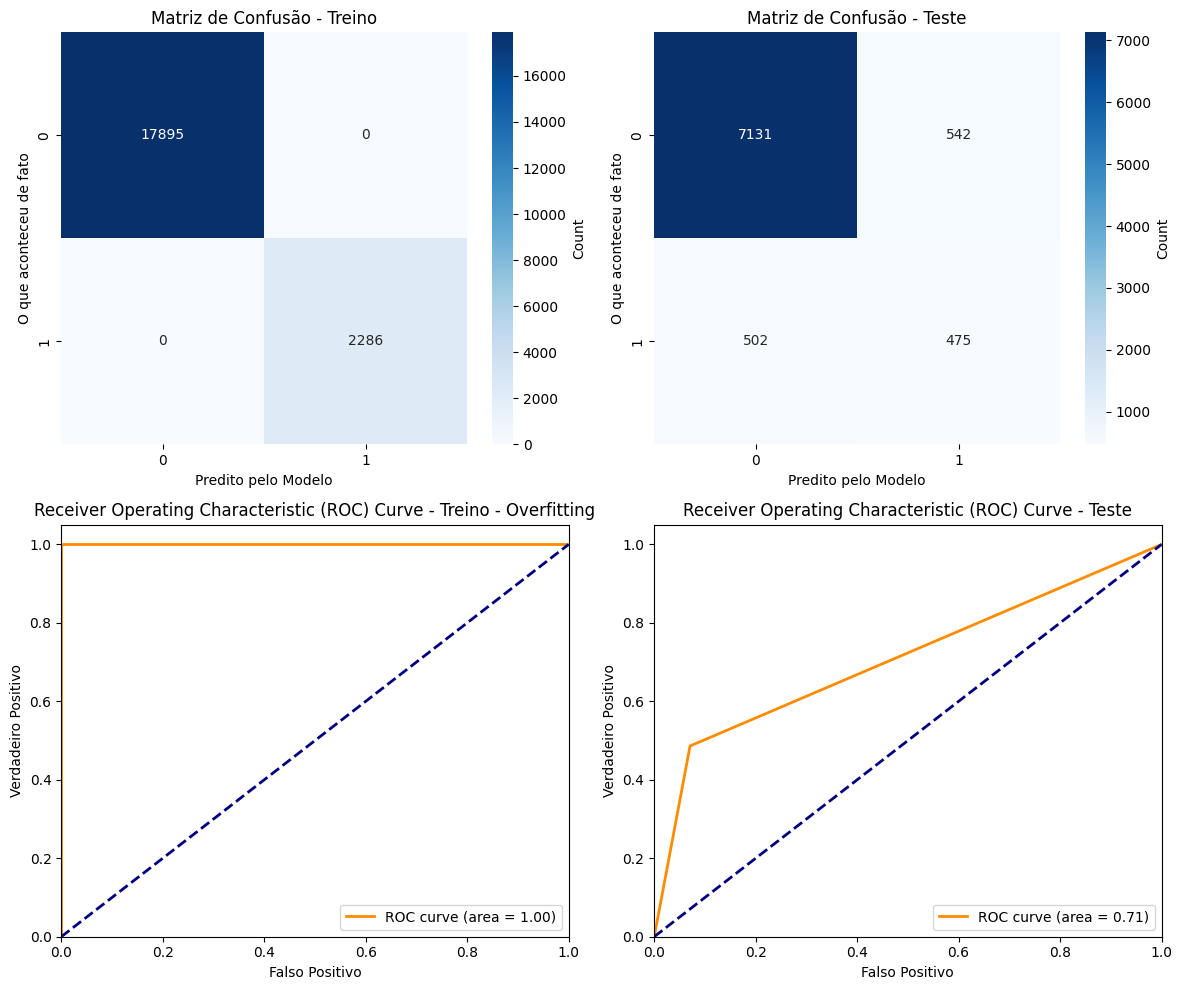

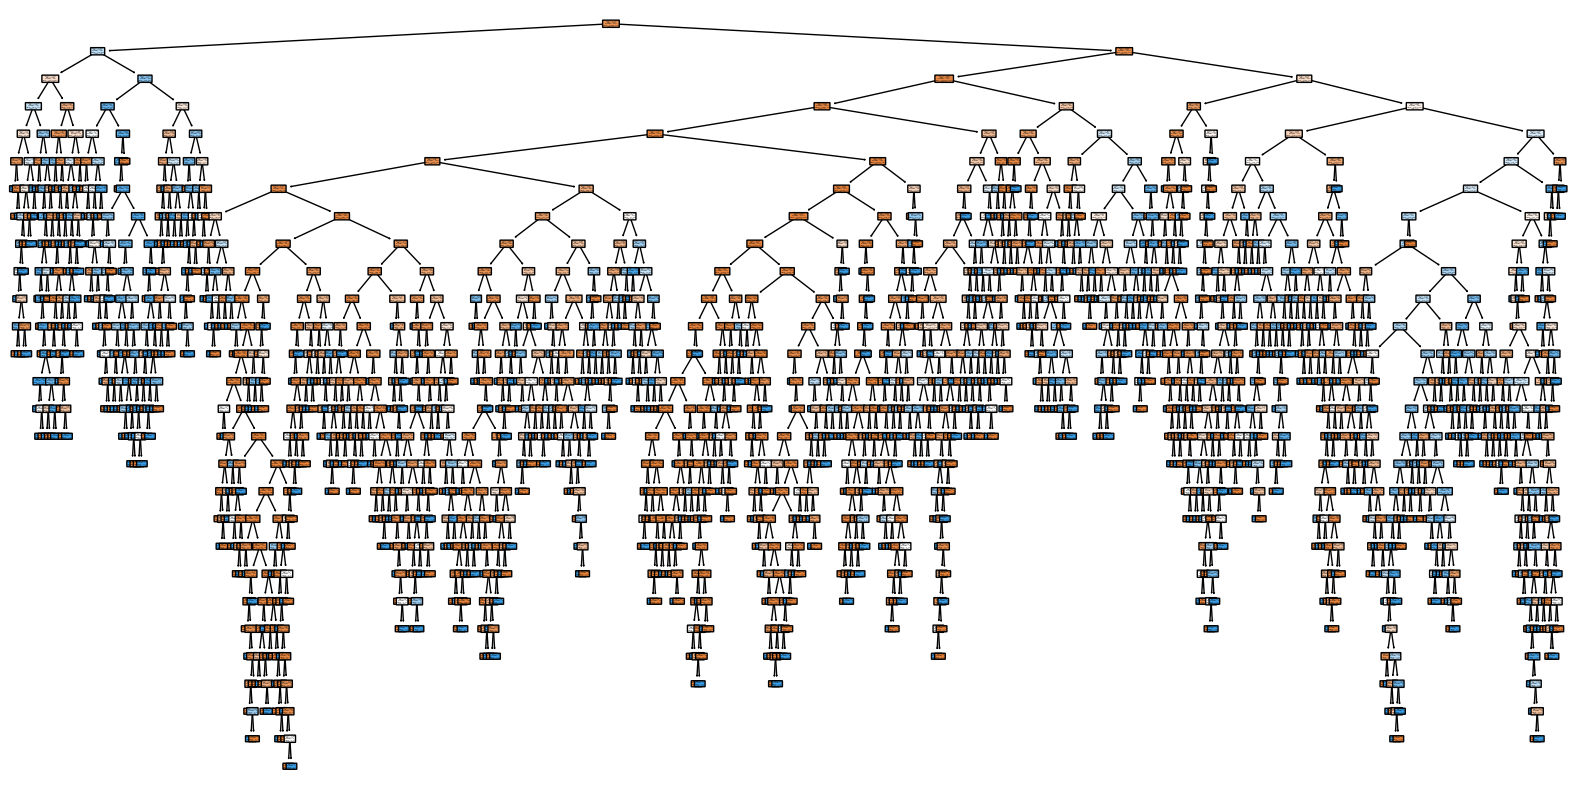

In [14]:
def train_score_plot_decision_tree_unoptmized(df, target_column, max_depth=None, random_state=88):
	# Separate features and target
	X = df.drop(columns=[target_column])
	y = df[target_column]

	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=88)

	# Train the decision tree classifier
	tree = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state)
	tree.fit(X_train, y_train)

	#### Verificando uma predição feita pelo modelo
	# Adicionando coluna de score (probabilidades) e classificação ao DataFrame de treino
	score = tree.predict_proba(X_train)[:, 1]
	classf = tree.predict(X_train)
	X_train['prediction_1'] = score
	X_train['class'] = classf

	#### Verificando uma predição feita pelo modelo agora na base de teste
	# Adicionando coluna de score (probabilidades) e classificação ao DataFrame de teste
	scoret = tree.predict_proba(X_test)[:, 1]
	classft = tree.predict(X_test)
	X_test['prediction_1'] = scoret
	X_test['class'] = classft

	# Predições
	y_train_pred = classf
	y_test_pred = classft

	# Criando a grade 2x2 para os gráficos
	fig, axs = plt.subplots(2, 2, figsize=(12, 10))

	# Calculando a Matriz de Confusão para o conjunto de treino
	conf_matrix = confusion_matrix(y_train, y_train_pred)
	sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'}, ax=axs[0, 0])
	axs[0, 0].set_xlabel('Predito pelo Modelo')
	axs[0, 0].set_ylabel('O que aconteceu de fato')
	axs[0, 0].set_title('Matriz de Confusão - Treino')

	# Calculando a Matriz de Confusão para o conjunto de teste
	conf_matrix = confusion_matrix(y_test, y_test_pred)
	sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'}, ax=axs[0, 1])
	axs[0, 1].set_xlabel('Predito pelo Modelo')
	axs[0, 1].set_ylabel('O que aconteceu de fato')
	axs[0, 1].set_title('Matriz de Confusão - Teste')

	# Calculando a curva ROC e a área sob a curva para o conjunto de treino
	fpr, tpr, _ = roc_curve(y_train, classf)
	roc_auc = auc(fpr, tpr)
	axs[1, 0].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
	axs[1, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
	axs[1, 0].set_xlim([0.0, 1.0])
	axs[1, 0].set_ylim([0.0, 1.05])
	axs[1, 0].set_xlabel('Falso Positivo')
	axs[1, 0].set_ylabel('Verdadeiro Positivo')
	axs[1, 0].set_title('Receiver Operating Characteristic (ROC) Curve - Treino - Overfitting')
	axs[1, 0].legend(loc='lower right')

	# Calculando a curva ROC e a área sob a curva para o conjunto de teste
	fpr, tpr, _ = roc_curve(y_test, classft)
	roc_auc = auc(fpr, tpr)
	axs[1, 1].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
	axs[1, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
	axs[1, 1].set_xlim([0.0, 1.0])
	axs[1, 1].set_ylim([0.0, 1.05])
	axs[1, 1].set_xlabel('Falso Positivo')
	axs[1, 1].set_ylabel('Verdadeiro Positivo')
	axs[1, 1].set_title('Receiver Operating Characteristic (ROC) Curve - Teste')
	axs[1, 1].legend(loc='lower right')

	plt.tight_layout()
	plt.show()

	# Plot the decision tree
	plt.figure(figsize=(20, 10))
	plot_tree(tree, filled=True, feature_names=X.columns, class_names=['No', 'Yes'], rounded=True)
	plt.show()

	return tree

# Apply the function to the dataframe
unoptimized_tree = train_score_plot_decision_tree_unoptmized(df_pca, 'y', max_depth=None)


#### Optimized Tree

In [18]:
def best_model(df, target_column, random_state=88):
	# Separar características e alvo
	X = df.drop(columns=[target_column])
	y = df[target_column]

	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=88)

	model = DecisionTreeClassifier(random_state=random_state)

	############### Para lembrar os parâmetros da árvore ###########################
#     model_dt = DecisionTreeClassifier(
#     criterion='gini',  # Critério utilizado para medir a qualidade de uma divisão ('gini' ou 'entropy').
#     splitter='best',  # Estratégia utilizada para escolher a divisão em cada nó ('best' ou 'random').
#     max_depth=3,  # Profundidade máxima da árvore. None significa que os nós serão expandidos até que todas as folhas sejam puras ou contenham menos amostras do que min_samples_split.
#     min_samples_split=0.2,  # Número mínimo de amostras necessárias para dividir um nó interno.
#     min_samples_leaf=1,  # Número mínimo de amostras necessárias para estar em um nó folha.
#     min_weight_fraction_leaf=0.0,  # Fração mínima ponderada do total da soma dos pesos necessária para estar em um nó folha.
#     max_features=None,  # Número de recursos a serem considerados ao procurar a melhor divisão.
#     random_state=None,  # Semente do gerador de números aleatórios utilizado para a tomada de decisões de divisão quando splitter == 'random'.
#     max_leaf_nodes=None,  # Número máximo de nós folha.
#     min_impurity_decrease=0.0,  # Um nó será dividido se a divisão induzir um decréscimo na impureza maior ou igual a este valor.
#     class_weight=None  # Peso das classes. Pode ser um dicionário de classes ou 'balanced'.
# )
################################################################################

	# Definindo os parâmetros para o grid search
	param_grid = {
		'criterion': ['gini', 'entropy'],
		'splitter': ['best', 'random'],
		'max_depth': [3, 5],  # Profundidade máxima da árvore
		'min_samples_split': [0.01, 0.05],  # Número mínimo de amostras necessárias para dividir um nó interno.
		'min_samples_leaf': [0.01, 0.05],  # Número mínimo de amostras necessárias para estar em um nó folha.
		'max_features': ['sqrt', 'log2', None],  # Número de recursos a serem considerados ao procurar a melhor divisão.
		'class_weight': ['balanced', None]  # Peso das classes. Pode ser um dicionário de classes ou 'balanced'.
	}

	# Calculando a quantidade total de modelos que serão treinados
	num_models = len(param_grid['splitter']) * len(param_grid['criterion']) * len(param_grid['max_depth']) * len(param_grid['min_samples_split']) * len(param_grid['min_samples_leaf']) * len(param_grid['max_features']) * len(param_grid['class_weight']) * 5  # 5 é o número de folds na validação cruzada (cv)
	print(f"Total de Modelos a serem Treinados: {num_models}")

	# Definindo o objeto GridSearchCV
	grid = GridSearchCV(model,
						param_grid,
						cv=5,
						scoring='roc_auc',  # 'accuracy' 'precision' 'recall' 'f1'
						n_jobs=-1)

	# Treinando o modelo com o grid search
	grid.fit(X_train, y_train)

	# Exibindo os melhores parâmetros encontrados pelo grid search
	print("Melhores Parâmetros: ", grid.best_params_)

	# Exibindo a melhor pontuação (score) atingida pelo modelo com os melhores parâmetros
	print("Melhor AUC: ", grid.best_score_)

	# Utilizando o melhor modelo para fazer previsões
	# predictions = grid.best_estimator_.predict(X_test)

	return grid.best_estimator_

# Aplicar a função ao dataframe
best_model_dt = best_model(df_pca, 'y')


Total de Modelos a serem Treinados: 960
Melhores Parâmetros:  {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 0.01, 'min_samples_split': 0.01, 'splitter': 'best'}
Melhor AUC:  0.9060891728813866
